In [1]:
from scipy.io import loadmat
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from tqdm import tqdm
from scipy.linalg import eigh, pinv

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
DATASET_PATH = '/content/drive/MyDrive/Brain-Computer Interfaces/Motor Imagery Dataset/'
# mat = loadmat(DATASET_PATH + 'data_set_IVa_al.mat')
mat = loadmat(DATASET_PATH + 'BCICIV_calib_ds1e_100Hz.mat')

In [3]:
cnt = mat['cnt'] * 0.1
mrk = mat['mrk']
nfo = mat['nfo']
x = [each[0] for each in nfo['xpos'][0][0]]
y = [each[0] for each in nfo['ypos'][0][0]]
trials = mrk[0][0][0][0]
labels = mrk[0][0][1][0]
fs = nfo['fs'][0][0][0][0]
channels = [each[0] for each in nfo['clab'][0][0][0]]
channel_poses = [[x[i], y[i]] for i in range(len(x))]
# label_names = [each[0] for each in nfo['classes'][0][0][0]]
print('cnt.shape', cnt.shape)
print('trials', trials[:10], 'trials.shape', trials.shape)
print('labels', labels[:10], 'labels.shape', labels.shape)
print('fs', fs)
print('channels', channels)
# print('label_names', label_names)

cnt.shape (190330, 59)
trials [2092 2892 3692 4492 5292 6092 6892 7692 8492 9292] trials.shape (200,)
labels [ 1  1 -1  1 -1 -1 -1 -1 -1  1] labels.shape (200,)
fs 100
channels ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']


## Preprocessing

In [4]:
def plot_magnitude_spectrum(sig, sr, title='signal', color='b'):
    n = len(sig)
    rf = np.linspace(0, sr / 2, num=round(n/2))
    fx = np.fft.fft(sig)
    fx = fx[:round(len(sig)/2)]                 # select half of all coeficients 
    fx = np.absolute(fx)                        # caculate magnitudes
    plt.figure(figsize=(18, 5))
    plt.plot(rf, fx, color=color)
    plt.xlabel('Frequency (Hz)')
    plt.title(title)
    plt.show()

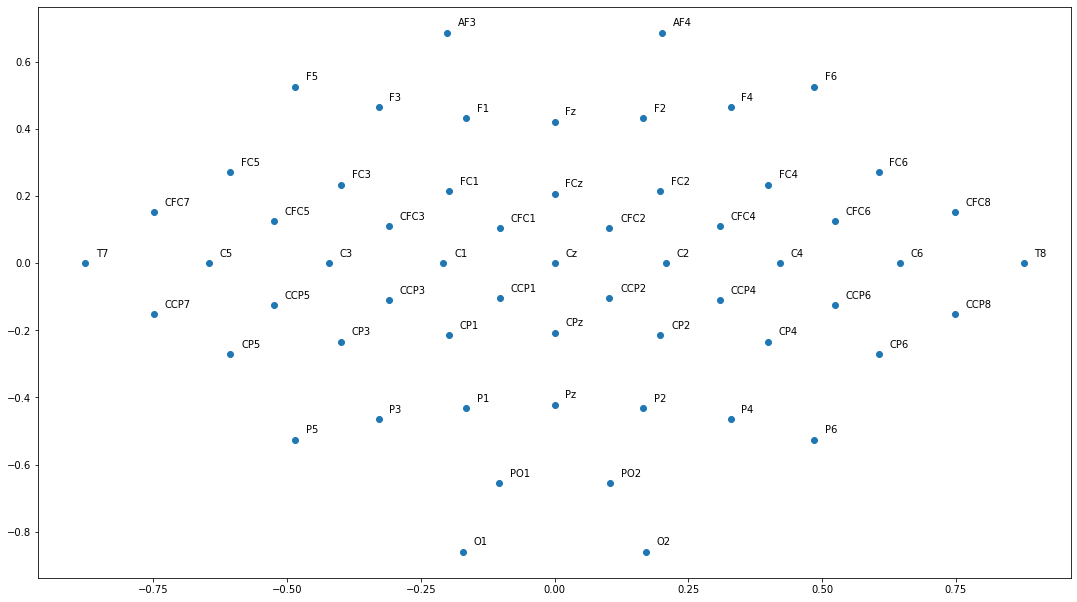

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.scatter(x, y)

for i, channel_name in enumerate(channels):
    ax.annotate(channel_name, (x[i] + 0.02, y[i] + 0.02))

In [6]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    banded_signals = []
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    for i in range(data.shape[1]):
        y = signal.filtfilt(b, a, data[:, i])
        banded_signals.append(y)
    return np.array(banded_signals).T

cnt_banded = butter_bandpass_filter(cnt, 8, 30, fs, 3)
cnt_banded.shape

(190330, 59)

In [7]:
def calculate_euclidean_distance(channel_poses, ci):
    distances = []
    for i in range(len(channel_poses)):
        score = np.sqrt(sum((np.array(channel_poses[i]) - np.array(ci)) ** 2))
        distances.append([i, score])    
        
    return sorted(distances, key=lambda x: x[1])[1:]


def find_laplacian_neighbours(channel_poses, dis, mode):
    if mode == 'low':
        cuton, cutoff = 0, 8
    elif mode == 'high':
        cuton, cutoff = 10, 22
    low_laplacian_neighbours_candidates = []
    for i, each in enumerate(channel_poses):
        for idx, d in dis[cuton:cutoff]:
            if i == idx:
                low_laplacian_neighbours_candidates.append(each + [d, idx])
                break

    for i in range(len(low_laplacian_neighbours_candidates)):
        cand_x, cand_y, d, idx = low_laplacian_neighbours_candidates[i]
        x_dis = np.sqrt((float(cand_x) - ci[0]) ** 2)
        y_dis = np.sqrt((float(cand_y) - ci[1]) ** 2)
        low_laplacian_neighbours_candidates[i] += [x_dis, y_dis]
    
    x_sorted = sorted(low_laplacian_neighbours_candidates, key = lambda x: x[-2])
    y_sorted = sorted(low_laplacian_neighbours_candidates, key = lambda x: x[-1])
    
    low_laplacian_neighbours = x_sorted[:2] + y_sorted[:2]
    return [each[:4] for each in low_laplacian_neighbours]


def calculate_neighbour_score(neighbours):
    neighbours = np.array(neighbours)
    d = neighbours[:, 2]
    w = (1 / d) / sum(1 / d)
    indices = [int(each) for each in neighbours[:, -1]]
    cnt_neighbours = cnt[:, indices] * w
    s = np.sum(cnt_neighbours, axis=1)
    cnt_final = cnt[:, 28] - s
    return cnt_final


def laplacian_filter(ch_names, mode='low'):
    laplaced_channels = []
    for each in ch_names:
        channel_idx = channels.index(each)
        ci = [x[channel_idx], y[channel_idx]]
        dis = calculate_euclidean_distance(channel_poses, ci)
        low_laplacian_neighbours = find_laplacian_neighbours(channel_poses, dis, mode=mode)
        laplaced_channels.append(calculate_neighbour_score(low_laplacian_neighbours))
    return np.array(laplaced_channels).T


def car_filter(the_cnt):
    ref = np.mean(the_cnt, axis=1)
    cnt_localized = the_cnt - np.mean(the_cnt, axis=1).reshape((the_cnt.shape[0], 1))
    return cnt_localized

In [8]:
cnt_localized = car_filter(cnt_banded)
cnt.shape

(190330, 59)

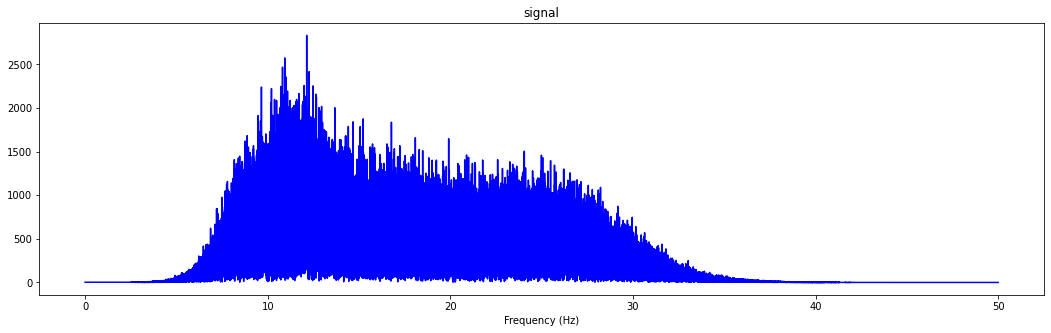

In [9]:
plot_magnitude_spectrum(cnt_localized[:, 56], fs)

## Extract Trials

In [10]:
left_trials, foot_trials = np.zeros((400, 59, 100)), np.zeros((400, 59, 100))
c1, c2 = 0, 0

for i in range(len(trials)):
    trial_signal = np.array(cnt_localized[trials[i]:trials[i] + 400, :])
    if labels[i] == 1:
        left_trials[:, :, c1] = trial_signal
        c1 += 1
    elif labels[i] == -1:    
        foot_trials[:, :, c2] = trial_signal
        c2 += 1

left_trials, foot_trials = np.array(left_trials), np.array(foot_trials)
left_trials.shape, foot_trials.shape

((400, 59, 100), (400, 59, 100))

In [11]:
def check_NA(idx):
    for trial in trials:
        if (idx >= trial and idx <= trial) or (idx + 400 >= trial and idx + 400 <= trial):
            return False
    return True

In [12]:
NA_trials = np.zeros((400, 59, 1000))
nac = 0

for i in range(len(cnt)):
    if check_NA(i):
        trial_signal = np.array(cnt_localized[i:i + 400, :])
        if trial_signal.shape[0] == 400:
            NA_trials[:, :, nac] = trial_signal
            nac += 1
            if nac == 1000:
                break
            
NA_trials = np.array(NA_trials)
NA_trials.shape

(400, 59, 1000)

## Feature Extraction

In [13]:
def feature_extractor(inp):
    inp_features = []
    for i in range(inp.shape[2]):
        trial = inp[:, :, i]
        v = np.var(trial, axis=0)
        all_trial_features = np.array(list(v))
        inp_features.append(all_trial_features) 
    return np.array(inp_features).T

left_features = feature_extractor(left_trials)
foot_features = feature_extractor(foot_trials)
NA_features = feature_extractor(NA_trials)

left_features.shape, foot_features.shape, NA_features.shape

((59, 100), (59, 100), (59, 1000))

## Variance-based RL (2 - 3 classes)

In [92]:
X = list(left_features.T) + list(foot_features.T) + list(NA_features.T)
y = [-1] * left_features.T.shape[0] + [0] * NA_features.T.shape[0] + [1] * foot_features.T.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)
X_train = np.array(X_train)
X_test = np.array(X_test)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)
print(len(X), len(y))
print(len(X_train), len(y_train), len(X_test), len(y_test))

1200 1200
840 840 360 360


In [63]:
X = list(left_features.T) + list(foot_features.T)
y = [0] * left_features.T.shape[0] + [1] * foot_features.T.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)
X_train = np.array(X_train)
X_test = np.array(X_test)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)
print(len(X), len(y))
print(len(X_train), len(y_train), len(X_test), len(y_test))

200 200
140 140 60 60


In [15]:
!pip install stable_baselines3

In [64]:
import gym 
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import numpy as np
import random
import os
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy

In [65]:
class SignalEnv(Env):
    def __init__(self, X_set, y_set):
        self.X, self.y = X_set, y_set
        self.action_space = Discrete(2)
        self.observation_space = Box(low=-1, high=1, shape=(self.X[0].shape[0],))
        self.state = 0
        
    def step(self, action):
        
        # Calculate reward
        if self.y[self.state] == action: 
            reward = 1 
        else: 
            reward = -1 
        
        info = {}
        self.state = self.state + 1 

        # Check if done
        if self.state >= len(self.X): 
            return _, reward, True, info
        else:
            return np.array(self.X[self.state]), reward, False, info

    def render(self):
        pass
    
    def reset(self):
        self.state = 0
        return np.array(self.X[self.state])

In [66]:
env = SignalEnv(X_train, y_train)
print(env.action_space.sample())
print(env.observation_space.sample())

1
[-9.3546465e-02  7.2064716e-01  1.4205503e-01 -4.1816261e-01
 -5.1290280e-01  7.0036697e-01  8.0390257e-01  5.5763870e-01
  2.0478228e-01  3.7968028e-01 -7.0128262e-01  9.9133056e-01
  3.2855421e-02 -3.1021288e-01 -9.4714940e-01  7.6670736e-01
 -2.4485141e-01  4.7929007e-01  8.1766822e-04 -6.1976498e-01
  7.9781640e-01 -9.7332597e-01  7.3300904e-01 -3.9439812e-01
  5.2447371e-02  3.4146690e-01  3.2151616e-01  7.8976852e-01
 -4.7206268e-01  9.8545760e-01 -3.6299404e-02 -8.9857632e-01
  1.8325102e-01 -2.9357338e-01  3.6296684e-01 -1.1216574e-01
  7.8329492e-01 -5.6585819e-01  8.2961047e-01  5.1580334e-01
  8.8029486e-01 -2.4090871e-02  7.4530780e-02  6.4454150e-01
 -4.4075134e-01 -6.9080913e-01 -2.4036707e-01  7.7166414e-01
 -9.8685604e-01 -6.8622965e-01 -9.1519290e-01  2.6980010e-01
  9.1723412e-02  5.6174135e-01 -3.3842471e-01  6.6647673e-01
  5.4366738e-01  9.6504027e-01  5.3078189e-02]


In [67]:
episodes = 5
for episode in range(1, episodes + 1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
    print('Episode:{} Score:{}'.format(episode, score))
    
env.close()

Episode:1 Score:-20
Episode:2 Score:4
Episode:3 Score:-10
Episode:4 Score:-12
Episode:5 Score:8


In [61]:
log_path = '/content/drive/MyDrive/Brain-Computer Interfaces/logs/'
model = PPO("MlpPolicy", env, tensorboard_log=log_path)
model.learn(total_timesteps=400000)

In [27]:
evaluate_policy(model, env, n_eval_episodes=10, render=False)

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


(36.0, 0.0)

In [25]:
model.save('/content/drive/MyDrive/Brain-Computer Interfaces/Saved Models (RL)/PPO_2')

In [62]:
attempts, corrects = 0, 0
env = SignalEnv(X_test, y_test)
obs = env.reset()
cc = 0
while True:
    action, _ = model.predict(obs) 
    obs, reward, done, info = env.step(action)
    attempts += 1
    if reward > 0:
        corrects += 1
    if done: 
        print('info', info)
        break
    cc += 1

print(corrects, attempts)
print('Accuracy:', corrects / len(X_test))

info {}
52 60
Accuracy: 0.8666666666666667


## Variance-based ML (2 - 3 classes)

In [70]:
X = list(left_features.T) + list(foot_features.T)
y = [0] * left_features.T.shape[0] + [1] * foot_features.T.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)
print(len(X), len(y))
print(len(X_train), len(y_train), len(X_test), len(y_test))

200 200
140 140 60 60


In [28]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        30
           1       0.50      0.50      0.50        30

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.50        60
weighted avg       0.50      0.50      0.50        60



In [29]:
clf = svm.SVC(kernel='poly')
# scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
# X_train = scaling.transform(X_train)
# X_test = scaling.transform(X_test)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77        30
           1       0.79      0.73      0.76        30

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60



In [30]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88        30
           1       0.87      0.90      0.89        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



## CSP

In [34]:
X = list(left_trials.T) + list(foot_trials.T)
y = [0] * left_trials.T.shape[0] + [1] * foot_trials.T.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)

X = np.array(X)
y = np.array(y)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print('X:', X.shape, 'y:', y.shape)
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_test:', X_test.shape, 'y_test:', y_test.shape)

X: (200, 59, 400) y: (200,)
X_train: (140, 59, 400) y_train: (140,)
X_test: (60, 59, 400) y_test: (60,)


In [35]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train_0, X_train_1 = [], []
for i in range(y_train.shape[0]):
    if y_train[i] == 0:
        X_train_0.append(X_train[i, :, :])
    elif y_train[i] == 1:
        X_train_1.append(X_train[i, :, :])

X_train_0 = np.array(X_train_0)
X_train_1 = np.array(X_train_1)

X_train_0.shape, X_train_1.shape

((70, 59, 400), (70, 59, 400))

In [36]:
X_test_0, X_test_1 = [], []
for i in range(X_test.shape[0]):
    if y_test[i] == 0:
        X_test_0.append(X_test[i, :, :])
    elif y_test[i] == 1:
        X_test_1.append(X_test[i, :, :])

X_test_0 = np.array(X_test_0)
X_test_1 = np.array(X_test_1)

X_test_0.shape, X_test_1.shape

((30, 59, 400), (30, 59, 400))

In [37]:
def select_filts(filt, col_num):

    temp = np.shape(filt)
    columns = np.arange(0,col_num)
    #print(columns)
    f = filt[:, columns]
    for ij in range(col_num):
        f[:, ij] = f[:, ij]/np.linalg.norm(f[:, ij])

    return f


def apply_CCACSP(X, f, col_num):

    f = np.transpose(f)

    temp = np.shape(X)
    num_trials = temp[0]

    #dat = np.zeros(np.shape(X), dtype = object)
    dat = np.zeros((num_trials, 2*col_num, temp[2]))
    for ik in range(num_trials):
        dat[ik,:,:] = np.matmul(f,X[ik,:,:])

    return dat

def my_cov(X, Y):
	avg_X = np.mean(X, axis=1)
	avg_Y = np.mean(Y, axis=1)

	X = X - avg_X[:,None]
	Y = Y - avg_Y[:,None]

	return np.matmul(X, Y.transpose())
 

def calc_CCACSP(x1,x2, numFilt):
    
    num_trials_1 = np.size(x1,0) 
    num_trials_2 = np.size(x2,0) 

    # number of channels and time samples should be the same between x1 and x2
    n_samps = np.size(x1,2)
    n_chans = np.size(x1,1) 

    c1_shifted = np.zeros([n_chans,n_chans])
    c2_shifted = np.zeros([n_chans,n_chans])
    c1 = np.zeros([n_chans,n_chans])
    c2 = np.zeros([n_chans,n_chans])

    range0 = range(0,n_samps-2)
    range1 = range(1,n_samps-1)
    range2 = range(2,n_samps)

    # estimate the covariances 
    for ik in range(num_trials_1):
        Samp = x1[ik]
        temp1 = 0.5*(Samp[:,range0]+Samp[:,range2])
        temp2 = Samp[:,range1]

        c1_shifted = c1_shifted+ my_cov(temp2, temp1)/np.trace(my_cov(temp2, temp1))
        c1 = c1+np.cov(x1[ik])/np.trace(np.cov(x1[ik]))

    c1_shifted = np.divide(c1_shifted,num_trials_1)
    c1 = np.divide(c1,num_trials_1)

    for ik in range(num_trials_2):
        Samp = x2[ik]
        temp1 = 0.5*(Samp[:,range0]+Samp[:,range2])
        temp2 = Samp[:,range1]
	
        c2_shifted = c2_shifted+ my_cov(temp2, temp1)/np.trace(my_cov(temp2, temp1))
        c2 = c2+np.cov(x2[ik])/np.trace(np.cov(x2[ik]))

    c2_shifted = np.divide(c2_shifted,num_trials_2)
    c2 = np.divide(c2,num_trials_2)
        

    # taking care of rank deficiency for a more robust result 
    D, V = eigh(c1+c2) 
    indx = np.argsort(D)
    indx = indx[::-1]
    d = D[indx[0:np.linalg.matrix_rank(c1+c2)]]
    W = V[:,indx[0:np.linalg.matrix_rank(c1+c2)]]
    W_T = np.matmul(np.sqrt(pinv(np.diag(d))),W.transpose())

    S1 = np.matmul(np.matmul(W_T,c1),W_T.transpose())
    S2 = np.matmul(np.matmul(W_T,c2),W_T.transpose())
    S1_shifted = np.matmul(np.matmul(W_T,c1_shifted),W_T.transpose())
    S2_shifted = np.matmul(np.matmul(W_T,c2_shifted),W_T.transpose())

    # find filters for class 1
    d,v = eigh(S1_shifted,S1+S2)
    indx = np.argsort(d)
    indx = indx[::-1]
    filts_1 = v.take(indx, axis=1)
    filts_1 = np.matmul(filts_1.transpose(),W_T)
    filts_1 = filts_1.transpose()
    filts_1 = select_filts(filts_1, numFilt)

    # find filters for class 2
    d,v = eigh(S2_shifted,S1+S2)
    indx = np.argsort(d)
    indx = indx[::-1]
    filts_2 = v.take(indx, axis=1)
    filts_2 = np.matmul(filts_2.transpose(),W_T)
    filts_2 = filts_2.transpose()
    filts_2 = select_filts(filts_2, numFilt)

    
    # concatenate filters for classes 1 and 2 and return 
    return np.concatenate((filts_1, filts_2), axis=1)

In [38]:
number_of_filters = 1
W = calc_CCACSP(X_train_0, X_train_1, number_of_filters)
print(W.shape)

(59, 2)


In [39]:
X_train_0.shape, X_test_0.shape

((70, 59, 400), (30, 59, 400))

## Transform Variance to CSP

In [40]:
X_train_0_features, X_train_1_features = [], []

for i in range(X_train_0.shape[0]):
    trial = X_train_0[i, :, :]
    filtered_trial = np.dot(W.T, trial)
    # f = np.var(filtered_trial.T, axis=0)
    f = np.log10(np.var(filtered_trial.T, axis=0) / np.sum(np.var(filtered_trial.T, axis=0)))
    X_train_0_features.append(f)

for i in range(X_train_1.shape[0]):
    trial = X_train_1[i, :, :]
    filtered_trial = np.dot(W.T, trial)
    # f = np.var(filtered_trial.T, axis=0)
    f = np.log10(np.var(filtered_trial.T, axis=0) / np.sum(np.var(filtered_trial.T, axis=0)))
    X_train_1_features.append(f)

X_train_0_features = np.array(X_train_0_features).T
X_train_1_features = np.array(X_train_1_features).T

print(X_train_0_features.shape, X_train_1_features.shape)

(2, 70) (2, 70)


In [41]:
X_test_0_features, X_test_1_features = [], []

for i in range(X_test_0.shape[0]):
    trial = X_test_0[i, :, :]
    filtered_trial = np.dot(W.T, trial)
    # f = np.var(filtered_trial.T, axis=0)
    f = np.log10(np.var(filtered_trial.T, axis=0) / np.sum(np.var(filtered_trial.T, axis=0)))
    X_test_0_features.append(f)

for i in range(X_test_1.shape[0]):
    trial = X_test_1[i, :, :]
    filtered_trial = np.dot(W.T, trial)
    # f = np.var(filtered_trial.T, axis=0)
    f = np.log10(np.var(filtered_trial.T, axis=0) / np.sum(np.var(filtered_trial.T, axis=0)))
    X_test_1_features.append(f)

X_test_0_features = np.array(X_test_0_features).T
X_test_1_features = np.array(X_test_1_features).T

print(X_test_0_features.shape, X_test_1_features.shape)

(2, 30) (2, 30)


In [42]:
X_train = np.array(list(X_train_0_features.T) + list(X_train_1_features.T))
y_train = np.array([0] * X_train_0_features.shape[1] + [1] * X_train_1_features.shape[1])

X_test = np.array(list(X_test_0_features.T) + list(X_test_1_features.T))
y_test = np.array([0] * X_test_0_features.shape[1] + [1] * X_test_1_features.shape[1])

print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_test:', X_test.shape, 'y_test:', y_test.shape)

X_train: (140, 2) y_train: (140,)
X_test: (60, 2) y_test: (60,)


In [43]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        30
           1       0.93      0.93      0.93        30

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60



In [44]:
clf = svm.SVC(kernel='poly')
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       0.94      0.97      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



In [45]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        30
           1       0.93      0.93      0.93        30

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60



In [46]:
env_csp = SignalEnv(X_train, y_train)
print(env_csp.action_space.sample())
print(env_csp.observation_space.sample())

0
[ 0.8472749  -0.75773185]


In [47]:
episodes = 5
for episode in range(1, episodes + 1):
    state = env_csp.reset()
    done = False
    score = 0 
    
    while not done:
        action = env_csp.action_space.sample()
        n_state, reward, done, info = env_csp.step(action)
        score += reward
    print('Episode:{} Score:{}'.format(episode, score))
    
env.close()

Episode:1 Score:12
Episode:2 Score:-18
Episode:3 Score:18
Episode:4 Score:-4
Episode:5 Score:16


In [52]:
log_path = '/content/drive/MyDrive/Brain-Computer Interfaces/logs/'
model = DQN("MlpPolicy", env_csp, tensorboard_log=log_path)
model.learn(total_timesteps=400000)

In [ ]:
evaluate_policy(model, env, n_eval_episodes=10, render=False) 

In [49]:
model.save('/content/drive/MyDrive/Brain-Computer Interfaces/Saved Models (RL)/PPO_2')

In [55]:
attempts, corrects = 0, 0
env_csp = SignalEnv(X_test, y_test)
obs = env_csp.reset()
cc = 0
while True:
    action, _ = model.predict(obs)
    obs, reward, done, info = env_csp.step(action)
    attempts += 1
    if reward > 0:
        corrects += 1
    if done: 
        print('info', info)
        break
    cc += 1

print(corrects, attempts)
print('Accuracy:', corrects / len(X_test))

info {}
56 60
Accuracy: 0.9333333333333333


## Plot CSP

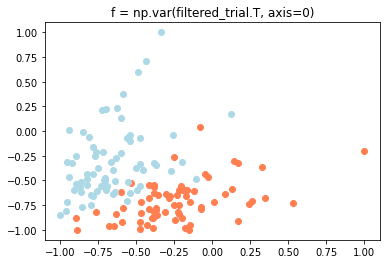

In [32]:
a, b = [], []
for i in range(X_train.shape[0]):
    if y_train[i] == 0:
        a.append(X_train[i, :])
    elif y_train[i] == 1:
        b.append(X_train[i, :])

a, b = np.array(a), np.array(b)
plt.scatter(a[:, 0], a[:, 1], c='coral')
plt.scatter(b[:, 0], b[:, 1], c='lightblue')
plt.title('f = np.var(filtered_trial.T, axis=0)')
plt.show()

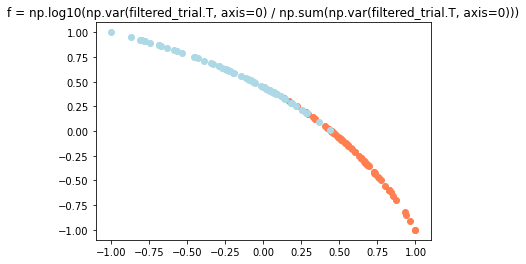

In [52]:
a, b = [], []
for i in range(X_train.shape[0]):
    if y_train[i] == 0:
        a.append(X_train[i, :])
    elif y_train[i] == 1:
        b.append(X_train[i, :])

a, b = np.array(a), np.array(b)
plt.scatter(a[:, 0], a[:, 1], c='coral')
plt.scatter(b[:, 0], b[:, 1], c='lightblue')
plt.title('f = np.log10(np.var(filtered_trial.T, axis=0) / np.sum(np.var(filtered_trial.T, axis=0)))')
plt.show()